# 3가지 모델 비교 실험
기존 코드는 아래 있습니다.

relevance, ensemble, mutiagent RAG 3가지 모델에 대해서 결과를 출력하고 Gound Truth를 가지고 평가진행.


In [1]:
import os
from dotenv import load_dotenv
from pprint import pprint

from langchain_teddynote import logging

from graph_relevancerag import RelevanceRAG
from graph_ensemblerag import EnsembleRAG
from graph_multiagentrag import MultiAgentRAG
from utils import *

# .env 파일 로드
load_dotenv(dotenv_path=".env")

# API 키 가져오기
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")

# LangSmith 추적 기능을 활성화합니다. (선택적)
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

# 프로젝트 이름을 입력합니다.
logging.langsmith("RAG Evaluation")

LangSmith 추적을 시작합니다.
[프로젝트명]
RAG Evaluation


In [2]:
def get_rag_instance(
    rag_method, 
    file_folder, 
    file_number, 
    # db_folder,
    chunk_size, 
    chunk_overlap,
    search_k,
    system_prompt, 
    model_name, 
    save_graph_png
):
    """
    RAG 클래스를 동적으로 받아서 인스턴스를 생성하는 함수
    
    Params:
        rag_method: RAG 방법 ("relevance-rag", "ensemble-rag", "multiagent-rag")
        file_folder: 논문 파일이 위치한 폴더 경로
        file_number: 처리할 논문 번호
        system_prompt: system prompt
        model_name: LLM 모델 명 ("gpt-4o", "gpt-4o-mini")
        save_graph_png: graph 저장 결정
        
    Return:
        생성된 RAG 모델 인스턴스
    """
    
    # RAG 모델 인스턴스 생성
    if rag_method == "relevance-rag":
        return RelevanceRAG(file_folder, file_number, chunk_size, chunk_overlap, search_k, system_prompt, model_name, save_graph_png)
        
    elif rag_method == "ensemble-rag":
        return EnsembleRAG(file_folder, file_number, chunk_size, chunk_overlap, search_k, system_prompt, model_name, save_graph_png)
        
    elif rag_method == "multiagent-rag":
        return MultiAgentRAG(file_folder, file_number, chunk_size, chunk_overlap, search_k, system_prompt, model_name, save_graph_png)


def main(
    data_folder:str="./data",
    file_num_list:list=[11],
    category_number:int=1, 
    chunk_size:int=500, 
    chunk_overlap:int=100, 
    search_k:int=10,       
    config_folder:str="./config",
    rag_method:str="multiagent-rag", 
    model_name:str="gpt-4o", 
    save_graph_png:bool=False, 
):
    category_names = ["CAM (Cathode Active Material)", "Electrode (half-cell)", "Morphological Properties", "Cathode Performance"]
    
    ## system_prompt 와 invoke_input 불러오기
    system_prompt = load_system_prompt(config_folder=config_folder, category_number=category_number, rag_method=rag_method)
    invoke_input = load_invoke_input(config_folder=config_folder, category_number=category_number, rag_method=rag_method)
    
    ## 각 논문에 대해 반복
    for i, file_number in enumerate(file_num_list):
        print(f"#####    {file_number}번째 논문    #####")
        print(f"##       rag method     : {rag_method}")
        print(f"##       category name  : {category_names[category_number-1]}")
        
        ## graph 호출
        voltai_graph = get_rag_instance(
            rag_method=rag_method, 
            file_folder=f"{data_folder}/input_data/", 
            file_number=file_number, 
            chunk_size=chunk_size, 
            chunk_overlap=chunk_overlap, 
            search_k=search_k, 
            system_prompt=system_prompt,
            model_name=model_name, 
            save_graph_png=save_graph_png,
        ).graph
        
        ## 질문이 딕셔너리 형태일 경우와 아닌 경우를 처리
        if isinstance(invoke_input, dict):
            
            result = voltai_graph.invoke(**invoke_input)
        else:
            result = voltai_graph.invoke(*invoke_input)

        ## RAG method에 따른 결과 확인
        if result.get("answer"):
            temp_answer = result["answer"][0][category_names[category_number-1]]
        elif result.get("discussion"):
            temp_answer = result["discussion"][category_names[category_number-1]]
        elif result.get("messages"):
            temp_answer = result["messages"][-1][category_names[category_number-1]]
        
        print(f"##       print {file_number} result")
        print("------------------------------------")
        pprint(temp_answer, sort_dicts=False)
        
        return temp_answer

In [18]:
file_num_list = [8,11]

## Category 1

In [19]:
# relevance_rag 
relevance_rag_c1_answer = main(file_num_list=file_num_list, category_number=1, rag_method="relevance-rag")

## ./config/relevance-rag/c1-system-prompt.yaml를 불러왔습니다.
## ./config/relevance-rag/c1-question.yaml를 불러왔습니다.
#####    8번째 논문    #####
##       rag method     : relevance-rag
##       category name  : CAM (Cathode Active Material)
##       paper_008 retriever를 생성했습니다.
##          - chunk_size    :500
##          - chunk_overlap :100
##          - retrieve_k    :10
        RELEVANCE CHECK : yes
##       print 8 result
------------------------------------
{'Stoichiometry information': {'NCM-111': {'Li ratio': 1.02,
                                           'Ni ratio': 0.3333,
                                           'Co ratio': 0.3333,
                                           'Mn ratio': 0.3333,
                                           'O ratio': 2.0},
                               'NCM-523': {'Li ratio': 1.02,
                                           'Ni ratio': 0.5,
                                           'Co ratio': 0.2,
                                           'Mn ratio

In [5]:
# ensemble_rag
ensemble_rag_answer = main(file_num_list=file_num_list, category_number=1, rag_method="ensemble-rag")

## ./config/ensemble-rag/c1-system-prompt.yaml를 불러왔습니다.
## ./config/ensemble-rag/c1-question.yaml를 불러왔습니다.
#####    8번째 논문    #####
##       rag method     : ensemble-rag
##       category name  : CAM (Cathode Active Material)
##       paper_008 retriever를 생성했습니다.
##          - chunk_size    :500
##          - chunk_overlap :100
##          - retrieve_k    :10
        RELEVANCE CHECK for ANSWER 1 : yes
        RELEVANCE CHECK for ANSWER 3 : yes
        RELEVANCE CHECK for ANSWER 2 : yes
        Success Discussion!
##       print 8 result
------------------------------------
{'Stoichiometry information': {'NCM-111': {'Li ratio': 1.02,
                                           'Ni ratio': 0.333,
                                           'Co ratio': 0.333,
                                           'Mn ratio': 0.333,
                                           'O ratio': 2.0},
                               'NCM-523': {'Li ratio': 1.02,
                                           'Ni rati

In [6]:
# multiagent_rag
multiagent_rag_c1_answer = main(file_num_list=file_num_list, category_number=1, rag_method="multiagent-rag")

## ./config/multiagent-rag/c1-system-prompt.yaml를 불러왔습니다.
## ./config/multiagent-rag/c1-question.yaml를 불러왔습니다.
#####    8번째 논문    #####
##       rag method     : multiagent-rag
##       category name  : CAM (Cathode Active Material)
##       paper_008 retriever를 생성했습니다.
##          - chunk_size    :500
##          - chunk_overlap :100
##          - retrieve_k    :10
##       print 8 result
------------------------------------
{'Stoichiometry information': {'NCM111': {'Li ratio': 1.02,
                                          'Ni ratio': 0.33,
                                          'Co ratio': 0.33,
                                          'Mn ratio': 0.33,
                                          'O ratio': 2.0},
                               'NCM523': {'Li ratio': 1.02,
                                          'Ni ratio': 0.5,
                                          'Co ratio': 0.2,
                                          'Mn ratio': 0.3,
                                  

In [9]:
type(multiagent_rag_c1_answer)

dict

In [17]:
def eval_df_generator(
    file_folder="./data/input_data/",      ## input 논문이 있는 폴더 위치
    file_num_list=[11, 16, 22],            ## 아직 8번 논문 안됨
    category_number=1,                     ## question 번호 1,2,3,4 중 하나
    data_folder:str="./data",
    chunk_size:int=500, 
    chunk_overlap:int=100,
    search_k:int=10,
    model_name:str="gpt-4o",   
    save_graph_png:bool=False, 
    config_folder:str="./config",
):
    eval_df = pd.DataFrame(columns=["paper_number", "relevance", "ensemble", "multiagent"])
    
    
    for i, file_number in enumerate(file_num_list):

        category_names = ["CAM (Cathode Active Material)", "Electrode (half-cell)", "Morphological Properties", "Cathode Performance"]
        relevance = get_rag_instance(
            rag_method="relevance-rag",
            file_folder=f"{data_folder}/input_data/", 
            file_number=file_number, 
            chunk_size=chunk_size, 
            chunk_overlap=chunk_overlap, 
            search_k=search_k, 
            system_prompt=load_system_prompt(config_folder=config_folder, category_number=category_number, rag_method="relevance-rag"),
            model_name=model_name, 
            save_graph_png=save_graph_png,
        ).graph
        
        ## 질문이 딕셔너리 형태일 경우와 아닌 경우를 처리
        invoke_input = load_invoke_input(config_folder=config_folder, category_number=category_number, rag_method="relevance-rag")
        if isinstance(invoke_input, dict):
            relevance_result= relevance.invoke(**invoke_input)
        else:
            relevance_result = relevance.invoke(*invoke_input)

        relevance_result = relevance_result["answer"][0][category_names[category_number-1]]

        ensemble = get_rag_instance(
            rag_method="ensemble-rag",
            file_folder=f"{data_folder}/input_data/", 
            file_number=file_number, 
            chunk_size=chunk_size, 
            chunk_overlap=chunk_overlap, 
            search_k=search_k, 
            system_prompt=load_system_prompt(config_folder=config_folder, category_number=category_number, rag_method="ensemble-rag"),
            model_name=model_name, 
            save_graph_png=save_graph_png,
        ).graph


        invoke_input = load_invoke_input(config_folder=config_folder, category_number=category_number, rag_method="ensemble-rag")
        if isinstance(invoke_input, dict):
            ensemble_result= ensemble.invoke(**invoke_input)
        else:
            ensemble_result = ensemble.invoke(*invoke_input)
        ensemble_result = ensemble_result["discussion"][category_names[category_number-1]]


        multi = get_rag_instance(
            rag_method="multiagent-rag",
            file_folder=f"{data_folder}/input_data/", 
            file_number=file_number, 
            chunk_size=chunk_size, 
            chunk_overlap=chunk_overlap, 
            search_k=search_k, 
            system_prompt=load_system_prompt(config_folder=config_folder, category_number=category_number, rag_method="multiagent-rag"),
            model_name=model_name, 
            save_graph_png=save_graph_png,
        ).graph
        invoke_input = load_invoke_input(config_folder=config_folder, category_number=category_number, rag_method="multiagent-rag")
        if isinstance(invoke_input, dict):
            multi_result= multi.invoke(**invoke_input)
        else:
            multi_result = multi.invoke(*invoke_input)

        multi_result = multi_result["messages"][-1][category_names[category_number-1]]

        ### result 저장
        ## gt 불러오기기
        if file_number < 10:
            file_name = f"paper_00{file_number}"
        elif file_number < 100:
            file_name = f"paper_0{file_number}"
        else:
            file_name = f"paper_{file_number}"
    
        # JSON 파일 경로
        file_path = f"./data/ground_truth/{file_name}_gt.json"

        # JSON 파일 읽기
        with open(file_path, "r", encoding="utf-8") as file:
            gt = json.load(file)

        ## df에 결과 저장하기       
        if category_number == 1:
            category_name = "CAM (Cathode Active Material)"
        elif category_number == 2:
            category_name = "Electrode (only for coin-cell (half-cell))"
        elif category_number == 3:
            category_name = "Morphological results"
        elif category_number == 4:
            category_name = "Cathode Performance"    
        else:
            raise


        

        
        eval_df.loc[i, "paper_number"] = file_number
        eval_df.loc[i, "relevance"] = [relevance_result]
        eval_df.loc[i, "ensemble"] = [ensemble_result]
        eval_df.loc[i, "multiagent"] = [multi_result]
        # eval_df.loc[i, "answer"] = [result["discussion"][category_name]]        
        eval_df.loc[i, "ground_truth"] = [gt[category_name]]
        
        
    return eval_df

In [26]:
eval = eval_df_generator(file_num_list=[8,42,56], category_number=1)

## ./config/relevance-rag/c1-system-prompt.yaml를 불러왔습니다.
##       paper_008 retriever를 생성했습니다.
##          - chunk_size    :500
##          - chunk_overlap :100
##          - retrieve_k    :10
## ./config/relevance-rag/c1-question.yaml를 불러왔습니다.
        RELEVANCE CHECK : no
        RELEVANCE CHECK : yes
## ./config/ensemble-rag/c1-system-prompt.yaml를 불러왔습니다.
##       paper_008 retriever를 생성했습니다.
##          - chunk_size    :500
##          - chunk_overlap :100
##          - retrieve_k    :10
## ./config/ensemble-rag/c1-question.yaml를 불러왔습니다.
        RELEVANCE CHECK for ANSWER 1 : no
        RELEVANCE CHECK for ANSWER 2 : no
        RELEVANCE CHECK for ANSWER 3 : yes
        Success Discussion!
        RELEVANCE CHECK for ANSWER 1 : no
        RELEVANCE CHECK for ANSWER 3 : yes
        RELEVANCE CHECK for ANSWER 2 : yes
        Success Discussion!
        RELEVANCE CHECK for ANSWER 1 : yes
        RELEVANCE CHECK for ANSWER 3 : yes
        RELEVANCE CHECK for ANSWER 2 : yes
        Succe

In [27]:
q1_eval = eval.copy()

In [ ]:
q1_eval

In [29]:
from metrics.metric_eval import evaluate_all_metrics

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/limseongbeom/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
def eval_sentence_generator(question_number, values):
    if question_number == 1:
        return f"The {values[0]} is {values[1]} commercially obtained, and synthesized with {values[2]}, and {values[3]}, and, {values[4]} for {values[5]} at {values[6]}, with {values[7]} doping and {values[8]} coating and {values[9]} treatment."
    elif question_number == 2:
        return f"The electrode is manufactured by {values[0]} with {values[1]} and {values[2]} is {values[3]} for {values[4]}."


In [33]:
q1_eval["ground_truth_sentence"] = q1_eval["ground_truth"].apply(lambda x: eval_sentence_generator(1, list(x[0].values())))
q1_eval["relevance_sentence"] = q1_eval["relevance"].apply(lambda x: eval_sentence_generator(1, list(x[0].values()))) 
q1_eval["ensemble_sentence"] = q1_eval["ensemble"].apply(lambda x: eval_sentence_generator(1, list(x[0].values()))) 
q1_eval["multiagent_sentence"] = q1_eval["multiagent"].apply(lambda x: eval_sentence_generator(1, list(x[0].values()))) 


In [35]:
## 모든 metric data frame
q1_all_metric_df_relevance = q1_eval[["ground_truth_sentence", "relevance_sentence"]].apply(
    lambda row: evaluate_all_metrics(row["ground_truth_sentence"], row["relevance_sentence"]), 
    axis=1
).apply(pd.Series)

## rouge 수정
q1_rouge_df = q1_all_metric_df_relevance["ROUGE"].apply(pd.Series)

## 최종 evaluation data frame
q1_eval_df = pd.concat([q1_eval, q1_all_metric_df_relevance.drop(columns=["ROUGE"]), q1_rouge_df], axis=1)

: 

## evalutaion notebook codes
임의로 문장 템플릿을 생성하여 llm answer의 value들을 넣어서 만든 문장을 비교하여 평가하는 코드입니다.  
`question1` 과 `question2`에 대해서만 진행했습니다.  
`question3` 와 `questino4`의 경우 수정될 수 있어 추후 진행하겠습니다. (금방할 수 있습니다)  

In [1]:

import os
from langchain_core.vectorstores.base import VectorStoreRetriever
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.documents.base import Document
from langchain_core.output_parsers import JsonOutputParser
from langchain_teddynote.messages import messages_to_history
from langchain.prompts import PromptTemplate
from pydantic import BaseModel, Field
# from langchain_teddynote.evaluator import GroundednessChecker

from dotenv import load_dotenv
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid

import yaml
import json

import pandas as pd
from metrics.metric_eval import evaluate_all_metrics

/Users/limseongbeom/anaconda3/envs/voltai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/limseongbeom/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# .env 파일 로드
load_dotenv(dotenv_path=".env")

# API 키 가져오기
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")

# LangSmith 추적 기능을 활성화합니다. (선택적)
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

In [3]:
def load_question(question_path:str="./config/questions/250115-SY-question.yaml"):
    with open(question_path, 'r') as file:
        questions = yaml.safe_load(file)
    
    question_list = []
    for i in range(1, 5):
        if i == 3 or i == 4:
           temp_question = f"""
{questions["main_question"]}{questions[f"add_question{i}"]}
{json.dumps(questions[f"example{i}"], ensure_ascii=False, indent=4)}
""" 
        else: 
            temp_question = f"""
{questions["main_question"]}
{json.dumps(questions[f"example{i}"], ensure_ascii=False, indent=4)}
"""

        question_list.append(temp_question)        

    return question_list

In [4]:
question_list = load_question()

### tools.py

In [5]:
def embedding_file(file_folder: str, file_name: str) -> VectorStoreRetriever:
    """문서를 청크 단위로 분할하고 임베딩 모델(text-embedding-ada-002)을 통해 임베딩하여 vector store에 저장합니다. 이후 vector store를 기반으로 검색하는 객체를 생성합니다.

    Args:
        file (str): pdf 문서 경로

    Returns:
        VectorStoreRetriever: 검색기
    """
    ## 긴 텍스트를 작은 청크로 나누는 데 사용되는 클래스
    splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=500,         ## 최대 청크 길이 정의
        chunk_overlap=100,      ## 청크 간 겹침 길이 정의
        separators=["\n\n"]     ## 텍스트를 나눌 때 사용할 구분자를 지정 (문단)
    )

    ## PDF 파일 불러오기
    loader = PyPDFLoader(f"{file_folder}/{file_name}.pdf")
    docs = loader.load_and_split(text_splitter=splitter)

    ## Embedding 생성 및 vector store에 저장
    embeddings = OpenAIEmbeddings()
    vector_store = FAISS.from_documents(
        documents=docs,         ## 벡터 저장소에 추가할 문서 리스트
        embedding=embeddings    ## 사용할 임베딩 함수
    )

    ## 검색기로 변환: 현재 벡터 저장소를 기반으로 VectorStoreRetriever 객체를 생성하는 기능을 제공
    retriever = vector_store.as_retriever(
        search_type="similarity",    ## 어떻게 검색할 것인지? default가 유사도
        search_kwargs={"k": 10}
    )

    return retriever

### graph.py

In [6]:
# GraphState 상태 정의
class GraphStateNEW(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer1: Annotated[str, "Answer1"]  # 답변
    answer2: Annotated[str, "Answer2"]  # 답변
    answer3: Annotated[str, "Answer3"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)
    discussion: Annotated[str, "Discussion"]
    

# Graph 구축
class DataExtractorNEW:
    def __init__(
        self, 
        file_folder:str="./data/input_data", 
        file_number:int=1, 
        db_folder:str="./vectordb"
    ):
        if file_number < 10:
            file_name = f"paper_00{file_number}"
        elif file_number < 100:
            file_name = f"paper_0{file_number}"
        else:
            file_name = f"paper_{file_number}"

        self.retriever = embedding_file(
            file_folder=file_folder, 
            file_name=file_name, 
            # db_folder=db_folder
        )
        
        self.model_1 = ChatOpenAI(model_name="gpt-4o", temperature=0.4)
        self.model_2 = ChatOpenAI(model_name="gpt-4o", temperature=0.6)
        self.model_3 = ChatOpenAI(model_name="gpt-4o", temperature=0.8)
        self.llm_answer_prompt = """
Based on the following document, please provide an answer to the given question.
Document:
{context}

Question:
{question}

Answer:
"""

        self.relevance_checker = ChatOpenAI(model="gpt-4o", temperature=0.5)
        self.relevance_check_template1 = """
You are a grader assessing relevance of a retrieved document to a user question. \n 
Here is the retrieved document: \n\n {context} \n\n
Here is the answer: {answer1} \n
If the document contains keyword(s) or semantic meaning related to the user answer, grade it as relevant. \n

Give a binary score 'yes' or 'no' score to indicate whether the retrieved document is relevant to the answer.
If the retrieved document does not contain the values or information being searched for, and 'None' is provided as the answer, check if the response accurately reflects the absence of the requested information. If the absence is accurate and justified, grade the document as relevant even if the values are 'None'.
"""
        self.relevance_check_template2 = """
You are a grader assessing relevance of a retrieved document to a user question. \n 
Here is the retrieved document: \n\n {context} \n\n
Here is the answer: {answer2} \n
If the document contains keyword(s) or semantic meaning related to the user answer, grade it as relevant. \n

Give a binary score 'yes' or 'no' score to indicate whether the retrieved document is relevant to the answer.
If the retrieved document does not contain the values or information being searched for, and 'None' is provided as the answer, check if the response accurately reflects the absence of the requested information. If the absence is accurate and justified, grade the document as relevant even if the values are 'None'.
"""
        self.relevance_check_template3 = """
You are a grader assessing relevance of a retrieved document to a user question. \n 
Here is the retrieved document: \n\n {context} \n\n
Here is the answer: {answer3} \n
If the document contains keyword(s) or semantic meaning related to the user answer, grade it as relevant. \n

Give a binary score 'yes' or 'no' score to indicate whether the retrieved document is relevant to the answer.
If the retrieved document does not contain the values or information being searched for, and 'None' is provided as the answer, check if the response accurately reflects the absence of the requested information. If the absence is accurate and justified, grade the document as relevant even if the values are 'None'.
"""
        
        self.discussion_model = ChatOpenAI(model="gpt-4o", temperature=0.5)
        self.discussion_prompt = """
You are an expert in extracting crucial information from battery-related research papers and generating the most accurate and comprehensive answers. Below are the answers provided by multiple LLM models to the same question, along with the retrieved document (context). Based on this information, generate the most reliable and well-rounded answer. Follow these guidelines when formulating your response:

1. Analyze the answers from each LLM model and extract the key information, prioritizing the overlapping points.
2. Evaluate how the retrieved document (context) relates to the answers from the LLM models, and add important content based on its credibility.
3. In case of ambiguity or conflicts between model answers, draw a clear conclusion based on the retrieved document.
4. The final answer should be accurate and detailed, incorporating all relevant information.
5. The output should be in JSON format, clearly separating and organizing the information.

### Input Data
1. Question: {question}
2. LLM Model 1 Answer: {answer1}
3. LLM Model 2 Answer: {answer2}
4. LLM Model 3 Answer: {answer3}
5. Retrieved Document (context): {context}
"""
        
        # 그래프 생성
        bulider = StateGraph(GraphStateNEW)

        # 노드 정의
        bulider.add_node("retrieve", self.retrieve_document)
        bulider.add_node("relevance_check1", self.relevance_check1)
        bulider.add_node("relevance_check2", self.relevance_check2)
        bulider.add_node("relevance_check3", self.relevance_check3)
        bulider.add_node("llm_answer1", self.llm_answer1)
        bulider.add_node("llm_answer2", self.llm_answer2)
        bulider.add_node("llm_answer3", self.llm_answer3)
        bulider.add_node("discussion_node", self.discussion_node)

       # 엣지 정의
        bulider.add_edge("retrieve", "llm_answer1")  # _start_ -> 검색 시작
        bulider.add_edge("retrieve", "llm_answer2")  # _start_ -> 검색 시작
        bulider.add_edge("retrieve", "llm_answer3")  # _start_ -> 검색 시작
        bulider.add_edge("llm_answer1", "relevance_check1")  # 답변 생성 -> 관련성 체크
        bulider.add_edge("llm_answer2", "relevance_check2")  # 답변 생성 -> 관련성 체크
        bulider.add_edge("llm_answer3", "relevance_check3")  # 답변 생성 -> 관련성 체크

        # 조건부 엣지를 추가합니다.
        bulider.add_conditional_edges(
            "relevance_check1",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
            self.is_relevant1,
            {
                "yes": "discussion_node",  # 관련성이 있으면 _end_로 이동합니다.
                "no": "retrieve",  # 관련성이 없으면 다시 검색합니다.
            },
        )
        bulider.add_conditional_edges(
            "relevance_check2",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
            self.is_relevant2,
            {
                "yes": "discussion_node",  # 관련성이 있으면 _end_로 이동합니다.
                "no": "retrieve",  # 관련성이 없으면 다시 검색합니다.
            },
        )
        bulider.add_conditional_edges(
            "relevance_check3",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
            self.is_relevant3,
            {
                "yes": "discussion_node",  # 관련성이 있으면 _end_로 이동합니다.
                "no": "retrieve",  # 관련성이 없으면 다시 검색합니다.
            },
        )

        bulider.add_edge("discussion_node", END)
        
        # 그래프 진입점 설정
        bulider.set_entry_point("retrieve")
        
        # 체크포인터 설정
        memory = MemorySaver()

        # 컴파일
        self.graph = bulider.compile(checkpointer=memory)        
        self.graph.get_graph().draw_mermaid_png(output_file_path="graph.png")

    
    def format_docs(self, docs: list[Document]) -> str:
        """문시 리스트에서 텍스트를 추출하여 하나의 문자로 합치는 기능을 합니다.

        Args:
            docs (list[Document]): 여러 개의 Documnet 객체로 이루어진 리스트

        Returns:
            str: 모든 문서의 텍스트가 하나로 합쳐진 문자열을 반환
        """
        return "\n\n".join(doc.page_content for doc in docs)
    
    
    def retrieve_document(self, state: GraphStateNEW) -> GraphStateNEW:
        """문서에서 검색하여 질문과 관련성 있는 문서를 찾습니다.

        Args:
            state (GraphState): 질문을 상태에서 가져옵니다.

        Returns:
            GraphState: 검색된 문서를 context 키에 저장한 상태 변수
        """        
        # 질문을 상태에서 가져옵니다.
        latest_question = state["question"]

        # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
        retrieved_docs = self.retriever.invoke(latest_question)

        # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
        retrieved_docs = self.format_docs(retrieved_docs)

        # 검색된 문서를 context 키에 저장합니다.
        return GraphStateNEW(context=retrieved_docs)
    
    
    def llm_answer1(self, state: GraphStateNEW) -> GraphStateNEW:
        """프롬프트에 따라 LLM이 질문에 대한 답변을 출력합니다. 

        Args:
            state (GraphState): 질문, 검색된 문서를 상태에서 가져옵니다. 

        Returns:
            GraphState: json 형태로 생성된 답변, (유저의 질문, 답변) 메세지를 저장한 상태 변수
        """        
        # 질문을 상태에서 가져옵니다.
        latest_question = state["question"]

        # 검색된 문서를 상태에서 가져옵니다.
        context = state["context"]

        # prompt 설정
        prompt = PromptTemplate(
            template=self.llm_answer_prompt,
            input_variables=["context", "question"],
            )

        # 체인 호출
        chain = prompt | self.model_1 | JsonOutputParser()

        response = chain.invoke(
            {
                "question": latest_question,
                "context": context,
                "chat_history": messages_to_history(state["messages"]),
            }
        )

        # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
        return GraphStateNEW(
            answer1=response,
            messages=[("user", latest_question), ("assistant", response)]
        )


    def llm_answer2(self, state: GraphStateNEW) -> GraphStateNEW:
        """프롬프트에 따라 LLM이 질문에 대한 답변을 출력합니다. 

        Args:
            state (GraphState): 질문, 검색된 문서를 상태에서 가져옵니다. 

        Returns:
            GraphState: json 형태로 생성된 답변, (유저의 질문, 답변) 메세지를 저장한 상태 변수
        """        
        # 질문을 상태에서 가져옵니다.
        latest_question = state["question"]

        # 검색된 문서를 상태에서 가져옵니다.
        context = state["context"]

        # prompt 설정
        prompt = PromptTemplate(
            template=self.llm_answer_prompt,
            input_variables=["context", "question"],
            )

        # 체인 호출
        chain = prompt | self.model_2 | JsonOutputParser()

        response = chain.invoke(
            {
                "question": latest_question,
                "context": context,
                "chat_history": messages_to_history(state["messages"]),
            }
        )

        # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
        return GraphStateNEW(
            answer2=response,
            messages=[("user", latest_question), ("assistant", response)]
        )


    def llm_answer3(self, state: GraphStateNEW) -> GraphStateNEW:
        """프롬프트에 따라 LLM이 질문에 대한 답변을 출력합니다. 

        Args:
            state (GraphState): 질문, 검색된 문서를 상태에서 가져옵니다. 

        Returns:
            GraphState: json 형태로 생성된 답변, (유저의 질문, 답변) 메세지를 저장한 상태 변수
        """        
        # 질문을 상태에서 가져옵니다.
        latest_question = state["question"]

        # 검색된 문서를 상태에서 가져옵니다.
        context = state["context"]

        # prompt 설정
        prompt = PromptTemplate(
            template=self.llm_answer_prompt,
            input_variables=["context", "question"],
            )

        # 체인 호출
        chain = prompt | self.model_3 | JsonOutputParser()

        response = chain.invoke(
            {
                "question": latest_question,
                "context": context,
                "chat_history": messages_to_history(state["messages"]),
            }
        )

        # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
        return GraphStateNEW(
            answer3=response,
            messages=[("user", latest_question), ("assistant", response)]
        )


    def relevance_check1(self, state: GraphStateNEW) -> GraphStateNEW:
        """답변과 검색 문서 간의 관련성을 평가합니다. 

        Args:
            state (GraphState): 검색된 문서와 답변을 가져옵니다. 

        Returns:
            GraphState: 관련성 점수를 저장한 상태 변수
        """    
        
        class GradeAnswer(BaseModel):
            """Binary scoring to evaluate the appropriateness of answers to retrieval"""

            binary_score: str = Field(
                description="Indicate 'yes' or 'no' whether the answer solves the question"
            )
            
        # 프롬프트 생성
        prompt = PromptTemplate(
            template=self.relevance_check_template1,
            input_variables=["context", "answer1"],
        )

        # 체인
        structured_relevance_checker = self.relevance_checker.with_structured_output(GradeAnswer)
        relevance_chain = prompt | structured_relevance_checker
        
        # retrieval_answer_relevant = GroundednessChecker(
        #     llm=self.relevance_checker, target="retrieval-answer"
        # ).create()

        # 관련성 체크를 실행("yes" or "no")
        response = relevance_chain.invoke(
            {"context": state["context"], "answer1": state["answer1"]}
        )

        print(f"        RELEVANCE CHECK for ANSWER 1 : {response.binary_score}")

        # 참고: 여기서의 관련성 평가기는 각자의 Prompt 를 사용하여 수정할 수 있습니다. 여러분들의 Groundedness Check 를 만들어 사용해 보세요!
        return GraphStateNEW(relevance1=response.binary_score)


    def relevance_check2(self, state: GraphStateNEW) -> GraphStateNEW:
        """답변과 검색 문서 간의 관련성을 평가합니다. 

        Args:
            state (GraphState): 검색된 문서와 답변을 가져옵니다. 

        Returns:
            GraphState: 관련성 점수를 저장한 상태 변수
        """    
        
        class GradeAnswer(BaseModel):
            """Binary scoring to evaluate the appropriateness of answers to retrieval"""

            binary_score: str = Field(
                description="Indicate 'yes' or 'no' whether the answer solves the question"
            )
            
        # 프롬프트 생성
        prompt = PromptTemplate(
            template=self.relevance_check_template2,
            input_variables=["context", "answer2"],
        )

        # 체인
        structured_relevance_checker = self.relevance_checker.with_structured_output(GradeAnswer)
        relevance_chain = prompt | structured_relevance_checker
        
        # retrieval_answer_relevant = GroundednessChecker(
        #     llm=self.relevance_checker, target="retrieval-answer"
        # ).create()

        # 관련성 체크를 실행("yes" or "no")
        response = relevance_chain.invoke(
            {"context": state["context"], "answer2": state["answer2"]}
        )

        print(f"        RELEVANCE CHECK for ANSWER 2 : {response.binary_score}")

        # 참고: 여기서의 관련성 평가기는 각자의 Prompt 를 사용하여 수정할 수 있습니다. 여러분들의 Groundedness Check 를 만들어 사용해 보세요!
        return GraphStateNEW(relevance2=response.binary_score)
    
    
    def relevance_check3(self, state: GraphStateNEW) -> GraphStateNEW:
        """답변과 검색 문서 간의 관련성을 평가합니다. 

        Args:
            state (GraphState): 검색된 문서와 답변을 가져옵니다. 

        Returns:
            GraphState: 관련성 점수를 저장한 상태 변수
        """    
        
        class GradeAnswer(BaseModel):
            """Binary scoring to evaluate the appropriateness of answers to retrieval"""

            binary_score: str = Field(
                description="Indicate 'yes' or 'no' whether the answer solves the question"
            )
            
        # 프롬프트 생성
        prompt = PromptTemplate(
            template=self.relevance_check_template3,
            input_variables=["context", "answer3"],
        )

        # 체인
        structured_relevance_checker = self.relevance_checker.with_structured_output(GradeAnswer)
        relevance_chain = prompt | structured_relevance_checker
        
        # retrieval_answer_relevant = GroundednessChecker(
        #     llm=self.relevance_checker, target="retrieval-answer"
        # ).create()

        # 관련성 체크를 실행("yes" or "no")
        response = relevance_chain.invoke(
            {"context": state["context"], "answer3": state["answer3"]}
        )

        print(f"        RELEVANCE CHECK for ANSWER 3 : {response.binary_score}")

        # 참고: 여기서의 관련성 평가기는 각자의 Prompt 를 사용하여 수정할 수 있습니다. 여러분들의 Groundedness Check 를 만들어 사용해 보세요!
        return GraphStateNEW(relevance3=response.binary_score)


    def is_relevant1(self, state: GraphStateNEW) -> GraphStateNEW:
        """관련성을 체크하는 함수

        Args:
            state (GraphState):

        Returns:
            GraphState: 관련성을 저장한 상태 변수
        """        
        return state["relevance1"]


    def is_relevant2(self, state: GraphStateNEW) -> GraphStateNEW:
        """관련성을 체크하는 함수

        Args:
            state (GraphState):

        Returns:
            GraphState: 관련성을 저장한 상태 변수
        """        
        return state["relevance2"]


    def is_relevant3(self, state: GraphStateNEW) -> GraphStateNEW:
        """관련성을 체크하는 함수

        Args:
            state (GraphState):

        Returns:
            GraphState: 관련성을 저장한 상태 변수
        """        
        return state["relevance3"]
    
    
    def discussion_node(self, state: GraphStateNEW) -> GraphStateNEW:
        prompt = PromptTemplate(
            template=self.discussion_prompt,
            input_variables=["question", "answer1", "answer2", "answer3", "context"],
        )
        discussion_chain = prompt | self.discussion_model | JsonOutputParser()
        response = discussion_chain.invoke(
            {
                "question": state["question"],
                "answer1": state["answer1"],
                "answer2": state["answer2"],
                "answer3": state["answer3"],
                "context": state["context"] 
            }
        )
        print(f"        Success Discussion!")

        return GraphStateNEW(discussion=response)

In [7]:
### ~250120 LangGraph RAG

# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)

# Graph 구축
class DataExtractor:
    def __init__(
        self, 
        file_folder:str="./data/input_data", 
        file_number:int=1, 
        # db_folder:str="./vectordb"
    ):
        if file_number < 10:
            file_name = f"paper_00{file_number}"
        elif file_number < 100:
            file_name = f"paper_0{file_number}"
        else:
            file_name = f"paper_{file_number}"

        self.retriever = embedding_file(
            file_folder=file_folder, 
            file_name=file_name, 
            # db_folder=db_folder
        )
        
        self.model = ChatOpenAI(model_name="gpt-4o", temperature=0.5)
        self.relevance_checker = ChatOpenAI(model="gpt-4o", temperature=0.5)
        self.llm_answer_prompt = """
        Based on the following document, please provide an answer to the given question.
        Document:
        {context}

        Question:
        {question}

        Answer:
        """
        self.relevance_check_template = """
        You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the answer: {answer} \n
        If the document contains keyword(s) or semantic meaning related to the user answer, grade it as relevant. \n
        
        Give a binary score 'yes' or 'no' score to indicate whether the retrieved document is relevant to the answer.
        If the retrieved document does not contain the values or information being searched for, and 'None' is provided as the answer, check if the response accurately reflects the absence of the requested information. If the absence is accurate and justified, grade the document as relevant even if the values are 'None'.
        """
        
        # 그래프 생성
        bulider = StateGraph(GraphState)

        # 노드 정의
        bulider.add_node("retrieve", self.retrieve_document)
        bulider.add_node("relevance_check", self.relevance_check)
        bulider.add_node("llm_answer", self.llm_answer)

       # 엣지 정의
        bulider.add_edge("retrieve", "llm_answer")  # _start_ -> 검색 시작
        bulider.add_edge("llm_answer", "relevance_check")  # 답변 생성 -> 관련성 체크

        # 조건부 엣지를 추가합니다.
        bulider.add_conditional_edges(
            "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
            self.is_relevant,
            {
                "yes": END,  # 관련성이 있으면 _end_로 이동합니다.
                "no": "retrieve",  # 관련성이 없으면 다시 검색합니다.
            },
        )

        # 그래프 진입점 설정
        bulider.set_entry_point("retrieve")
        
        # 체크포인터 설정
        memory = MemorySaver()

        # 컴파일
        self.graph = bulider.compile(checkpointer=memory)        
        self.graph.get_graph().draw_mermaid_png(output_file_path="graph.png")

    
    def format_docs(self, docs: list[Document]) -> str:
        """문시 리스트에서 텍스트를 추출하여 하나의 문자로 합치는 기능을 합니다.

        Args:
            docs (list[Document]): 여러 개의 Documnet 객체로 이루어진 리스트

        Returns:
            str: 모든 문서의 텍스트가 하나로 합쳐진 문자열을 반환
        """
        return "\n\n".join(doc.page_content for doc in docs)
    
    
    def retrieve_document(self, state: GraphState) -> GraphState:
        """문서에서 검색하여 질문과 관련성 있는 문서를 찾습니다.

        Args:
            state (GraphState): 질문을 상태에서 가져옵니다.

        Returns:
            GraphState: 검색된 문서를 context 키에 저장한 상태 변수
        """        
        # 질문을 상태에서 가져옵니다.
        latest_question = state["question"]

        # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
        retrieved_docs = self.retriever.invoke(latest_question)

        # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
        retrieved_docs = self.format_docs(retrieved_docs)

        # 검색된 문서를 context 키에 저장합니다.
        return GraphState(context=retrieved_docs)
    
    
    def llm_answer(self, state: GraphState) -> GraphState:
        """프롬프트에 따라 LLM이 질문에 대한 답변을 출력합니다. 

        Args:
            state (GraphState): 질문, 검색된 문서를 상태에서 가져옵니다. 

        Returns:
            GraphState: json 형태로 생성된 답변, (유저의 질문, 답변) 메세지를 저장한 상태 변수
        """        
        # 질문을 상태에서 가져옵니다.
        latest_question = state["question"]

        # 검색된 문서를 상태에서 가져옵니다.
        context = state["context"]

        # prompt 설정
        prompt = PromptTemplate(
            template=self.llm_answer_prompt,
            input_variables=["context", "question"],
            )

        # 체인 호출
        chain = prompt | self.model | JsonOutputParser()

        response = chain.invoke(
            {
                "question": latest_question,
                "context": context,
                "chat_history": messages_to_history(state["messages"]),
            }
        )

        # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
        return GraphState(
            answer=response,
            messages=[("user", latest_question), ("assistant", response)]
        )


    def relevance_check(self, state: GraphState) -> GraphState:
        """답변과 검색 문서 간의 관련성을 평가합니다. 

        Args:
            state (GraphState): 검색된 문서와 답변을 가져옵니다. 

        Returns:
            GraphState: 관련성 점수를 저장한 상태 변수
        """    
        
        class GradeAnswer(BaseModel):
            """Binary scoring to evaluate the appropriateness of answers to retrieval"""

            binary_score: str = Field(
                description="Indicate 'yes' or 'no' whether the answer solves the question"
            )
            
        # 프롬프트 생성
        prompt = PromptTemplate(
            template=self.relevance_check_template,
            input_variables=["context", "answer"],
        )

        # 체인
        structured_relevance_checker = self.relevance_checker.with_structured_output(GradeAnswer)
        relevance_chain = prompt | structured_relevance_checker
        
        # retrieval_answer_relevant = GroundednessChecker(
        #     llm=self.relevance_checker, target="retrieval-answer"
        # ).create()

        # 관련성 체크를 실행("yes" or "no")
        response = relevance_chain.invoke(
            {"context": state["context"], "answer": state["answer"]}
        )

        print(f"        RELEVANCE CHECK : {response.binary_score}")

        # 참고: 여기서의 관련성 평가기는 각자의 Prompt 를 사용하여 수정할 수 있습니다. 여러분들의 Groundedness Check 를 만들어 사용해 보세요!
        return GraphState(relevance=response.binary_score)


    def is_relevant(self, state: GraphState) -> GraphState:
        """관련성을 체크하는 함수

        Args:
            state (GraphState):

        Returns:
            GraphState: 관련성을 저장한 상태 변수
        """        
        return state["relevance"]

### output

In [8]:
def eval_df_generator(
    file_folder="./data/input_data/",      ## input 논문이 있는 폴더 위치
    file_num_list=[11, 16, 22],            ## 아직 8번 논문 안됨
    question_number=1,                     ## question 번호 1,2,3,4 중 하나
):
    eval_df = pd.DataFrame(columns=["paper_number", "question", "ground_truth", "answer", "context"])
    for i, file_number in enumerate(file_num_list):
        print(f"#####   {file_number}번째 논문    #####")
        voltai_graph = DataExtractor(
            file_folder=file_folder,
            file_number=file_number
        ).graph

        # config 설정(재귀 최대 횟수, thread_id)
        config = RunnableConfig(
            recursion_limit=20, 
            # configurable={"thread_id": str(uuid.uuid4())}
            configurable={"thread_id": random_uuid()}
        )

        # 4개의 질문에 대해 그래프 실행 및 출력
        print(f"    {question_number}번째 질문")
        result = voltai_graph.invoke(input={"question":question_list[question_number-1]}, config=config)

        ### result 저장
        ## gt 불러오기기
        if file_number < 10:
            file_name = f"paper_00{file_number}"
        elif file_number < 100:
            file_name = f"paper_0{file_number}"
        else:
            file_name = f"paper_{file_number}"
    
        # JSON 파일 경로
        file_path = f"./data/ground_truth/{file_name}_gt.json"

        # JSON 파일 읽기
        with open(file_path, "r", encoding="utf-8") as file:
            gt = json.load(file)

        ## df에 결과 저장하기       
        if question_number == 1:
            category_name = "CAM (Cathode Active Material)"
        elif question_number == 2:
            category_name = "Electrode (only for coin-cell (half-cell))"
        elif question_number == 3:
            category_name = "Morphological results"
        elif question_number == 4:
            category_name = "Cathode Performance"    
        else:
            raise
        
        eval_df.loc[i, "paper_number"] = file_number
        eval_df.loc[i, "question"] = result["question"].replace("\n", "")
        eval_df.loc[i, "answer"] = [result["answer"][0][category_name]]
        # eval_df.loc[i, "answer"] = [result["discussion"][category_name]]        
        eval_df.loc[i, "ground_truth"] = [gt[category_name]]
        eval_df.loc[i, "context"] = result["context"]
        
    return eval_df

In [9]:
def eval_df_generatorNEW(
    file_folder="./data/input_data/",      ## input 논문이 있는 폴더 위치
    file_num_list=[11, 16, 22],            ## 아직 8번 논문 안됨
    question_number=1,                     ## question 번호 1,2,3,4 중 하나
):
    eval_df = pd.DataFrame(columns=["paper_number", "question", "ground_truth", "answer", "context"])
    for i, file_number in enumerate(file_num_list):
        print(f"#####   {file_number}번째 논문    #####")
        voltai_graph = DataExtractorNEW(
            file_folder=file_folder,
            file_number=file_number
        ).graph

        # config 설정(재귀 최대 횟수, thread_id)
        config = RunnableConfig(
            recursion_limit=20, 
            # configurable={"thread_id": str(uuid.uuid4())}
            configurable={"thread_id": random_uuid()}
        )

        # 4개의 질문에 대해 그래프 실행 및 출력
        print(f"    {question_number}번째 질문")
        result = voltai_graph.invoke(input={"question":question_list[question_number-1]}, config=config)

        ### result 저장
        ## gt 불러오기기
        if file_number < 10:
            file_name = f"paper_00{file_number}"
        elif file_number < 100:
            file_name = f"paper_0{file_number}"
        else:
            file_name = f"paper_{file_number}"
    
        # JSON 파일 경로
        file_path = f"./data/ground_truth/{file_name}_gt.json"

        # JSON 파일 읽기
        with open(file_path, "r", encoding="utf-8") as file:
            gt = json.load(file)

        ## df에 결과 저장하기       
        if question_number == 1:
            category_name = "CAM (Cathode Active Material)"
        elif question_number == 2:
            category_name = "Electrode (only for coin-cell (half-cell))"
        elif question_number == 3:
            category_name = "Morphological results"
        elif question_number == 4:
            category_name = "Cathode Performance"    
        else:
            raise
        
        eval_df.loc[i, "paper_number"] = file_number
        eval_df.loc[i, "question"] = result["question"].replace("\n", "")
        # eval_df.loc[i, "answer"] = [result["answer"][0][category_name]]
        eval_df.loc[i, "answer"] = [result["discussion"][category_name]]        
        eval_df.loc[i, "ground_truth"] = [gt[category_name]]
        eval_df.loc[i, "context"] = result["context"]
        
    return eval_df

### eval

In [10]:
file_num_list = [8, 11, 16, 22, 33, 35, 39, 56]
# question_number = 2

In [11]:
q1_eval_frame = eval_df_generator(
    file_folder="./data/input_data/",       ## input 논문이 있는 폴더 위치
    file_num_list=file_num_list,            ## 아직 8번 논문 안됨
    question_number=1,        ## question 번호 1,2,3,4 중 하나
)

#####   8번째 논문    #####
    1번째 질문
        RELEVANCE CHECK : yes
#####   11번째 논문    #####
    1번째 질문
        RELEVANCE CHECK : yes
#####   16번째 논문    #####
    1번째 질문
        RELEVANCE CHECK : yes
#####   22번째 논문    #####
    1번째 질문
        RELEVANCE CHECK : yes
#####   33번째 논문    #####
    1번째 질문
        RELEVANCE CHECK : yes
#####   35번째 논문    #####
    1번째 질문
        RELEVANCE CHECK : yes
#####   39번째 논문    #####
    1번째 질문
        RELEVANCE CHECK : yes
#####   56번째 논문    #####
    1번째 질문
        RELEVANCE CHECK : yes


In [16]:
q1_eval_frameNEW = eval_df_generatorNEW(
    file_folder="./data/input_data/",       ## input 논문이 있는 폴더 위치
    file_num_list=file_num_list,            ## 아직 8번 논문 안됨
    question_number=1,        ## question 번호 1,2,3,4 중 하나
)

#####   8번째 논문    #####
    1번째 질문
        RELEVANCE CHECK for ANSWER 1 : no
        RELEVANCE CHECK for ANSWER 2 : yes
        RELEVANCE CHECK for ANSWER 3 : yes
        Success Discussion!
        RELEVANCE CHECK for ANSWER 2 : yes
        RELEVANCE CHECK for ANSWER 1 : yes
        RELEVANCE CHECK for ANSWER 3 : yes
        Success Discussion!
#####   11번째 논문    #####
    1번째 질문
        RELEVANCE CHECK for ANSWER 1 : yes
        RELEVANCE CHECK for ANSWER 3 : yes
        RELEVANCE CHECK for ANSWER 2 : yes
        Success Discussion!
#####   16번째 논문    #####
    1번째 질문
        RELEVANCE CHECK for ANSWER 2 : yes
        RELEVANCE CHECK for ANSWER 3 : yes
        RELEVANCE CHECK for ANSWER 1 : yes
        Success Discussion!
#####   22번째 논문    #####
    1번째 질문
        RELEVANCE CHECK for ANSWER 2 : yes
        RELEVANCE CHECK for ANSWER 1 : yes
        RELEVANCE CHECK for ANSWER 3 : yes
        Success Discussion!
#####   33번째 논문    #####
    1번째 질문
        RELEVANCE CHECK for ANSWER 1 

In [17]:
q2_eval_frame = eval_df_generator(
    file_folder="./data/input_data/",       ## input 논문이 있는 폴더 위치
    file_num_list=file_num_list,            ## 아직 8번 논문 안됨
    question_number=2,        ## question 번호 1,2,3,4 중 하나
)

#####   8번째 논문    #####
    2번째 질문
        RELEVANCE CHECK : yes
#####   11번째 논문    #####
    2번째 질문
        RELEVANCE CHECK : yes
#####   16번째 논문    #####
    2번째 질문
        RELEVANCE CHECK : yes
#####   22번째 논문    #####
    2번째 질문
        RELEVANCE CHECK : yes
#####   33번째 논문    #####
    2번째 질문
        RELEVANCE CHECK : yes
#####   35번째 논문    #####
    2번째 질문
        RELEVANCE CHECK : yes
#####   39번째 논문    #####
    2번째 질문
        RELEVANCE CHECK : no
        RELEVANCE CHECK : yes
#####   56번째 논문    #####
    2번째 질문
        RELEVANCE CHECK : yes


In [18]:
q2_eval_frameNEW = eval_df_generatorNEW(
    file_folder="./data/input_data/",       ## input 논문이 있는 폴더 위치
    file_num_list=file_num_list,            ## 아직 8번 논문 안됨
    question_number=2,        ## question 번호 1,2,3,4 중 하나
)

#####   8번째 논문    #####
    2번째 질문
        RELEVANCE CHECK for ANSWER 1 : no
        RELEVANCE CHECK for ANSWER 3 : yes
        RELEVANCE CHECK for ANSWER 2 : no
        Success Discussion!
        RELEVANCE CHECK for ANSWER 1 : yes
        RELEVANCE CHECK for ANSWER 2 : no
        RELEVANCE CHECK for ANSWER 3 : no
        Success Discussion!
        RELEVANCE CHECK for ANSWER 2 : yes
        RELEVANCE CHECK for ANSWER 1 : yes
        RELEVANCE CHECK for ANSWER 3 : no
        Success Discussion!
        RELEVANCE CHECK for ANSWER 3 : no
        RELEVANCE CHECK for ANSWER 1 : no
        RELEVANCE CHECK for ANSWER 2 : yes
        Success Discussion!
        RELEVANCE CHECK for ANSWER 1 : no
        RELEVANCE CHECK for ANSWER 2 : no
        RELEVANCE CHECK for ANSWER 3 : yes
        Success Discussion!
        RELEVANCE CHECK for ANSWER 2 : no
        RELEVANCE CHECK for ANSWER 1 : yes
        RELEVANCE CHECK for ANSWER 3 : yes
        Success Discussion!


GraphRecursionError: Recursion limit of 20 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [20]:
# q3_eval_frame = eval_df_generator(
#     file_folder="./data/input_data/",       ## input 논문이 있는 폴더 위치
#     file_num_list=file_num_list,            ## 아직 8번 논문 안됨
#     question_number=3,        ## question 번호 1,2,3,4 중 하나
# )

In [21]:
# q4_eval_frame = eval_df_generator(
#     file_folder="./data/input_data/",       ## input 논문이 있는 폴더 위치
#     file_num_list=file_num_list,            ## 아직 8번 논문 안됨
#     question_number=4,        ## question 번호 1,2,3,4 중 하나
# )

In [12]:
# q1_eval_frame

In [30]:
# q2_eval_frame

,paper_number,question,ground_truth,answer,context
0,11,Below are instructions for filling out items b...,[{'Active material to Conductive additive to B...,[{'Active material to Conductive additive to B...,or to utilize conductive additives such as gra...
1,16,Below are instructions for filling out items b...,[{'Active material to Conductive additive to B...,[{'Active material to Conductive additive to B...,Notes\nThe authors declare no competingﬁnancia...
2,22,Below are instructions for filling out items b...,[{'Active material to Conductive additive to B...,[{'Active material to Conductive additive to B...,2Scientific RepoRts | (2019) 9:8952...


In [24]:
# q3_eval_frame

In [25]:
# q4_eval_frame

#### 1. 임의로 설정한 sentence template에 value들을 넣어서 평가

In [19]:
def eval_sentence_generator(question_number, values):
    if question_number == 1:
        return f"The {values[0]} is {values[1]} commercially obtained, and synthesized with {values[2]}, and {values[3]}, and, {values[4]} for {values[5]} at {values[6]}, with {values[7]} doping and {values[8]} coating and {values[9]} treatment."
    elif question_number == 2:
        return f"The electrode is manufactured by {values[0]} with {values[1]} and {values[2]} is {values[3]} for {values[4]}."


In [20]:
q1_eval_frame["ground_truth_sentence"] = q1_eval_frame["ground_truth"].apply(lambda x: eval_sentence_generator(1, list(x[0].values())))
q1_eval_frame["answer_sentence"] = q1_eval_frame["answer"].apply(lambda x: eval_sentence_generator(1, list(x[0].values()))) 

In [21]:
q1_eval_frameNEW["ground_truth_sentence"] = q1_eval_frameNEW["ground_truth"].apply(lambda x: eval_sentence_generator(1, list(x[0].values())))
q1_eval_frameNEW["answer_sentence"] = q1_eval_frameNEW["answer"].apply(lambda x: eval_sentence_generator(1, list(x[0].values()))) 

In [33]:
q2_eval_frame["ground_truth_sentence"] = q2_eval_frame["ground_truth"].apply(lambda x: eval_sentence_generator(question_number=2, values=list(x[0].values())))
q2_eval_frame["answer_sentence"] = q2_eval_frame["answer"].apply(lambda x: eval_sentence_generator(question_number=2, values=list(x[0].values())))

In [ ]:
q2_eval_frameNEW["ground_truth_sentence"] = q2_eval_frameNEW["ground_truth"].apply(lambda x: eval_sentence_generator(1, list(x[0].values())))
q2_eval_frameNEW["answer_sentence"] = q2_eval_frameNEW["answer"].apply(lambda x: eval_sentence_generator(1, list(x[0].values()))) 

### all metric

In [22]:
## 모든 metric data frame
q1_all_metric_df = q1_eval_frame[["ground_truth_sentence", "answer_sentence"]].apply(
    lambda row: evaluate_all_metrics(row["ground_truth_sentence"], row["answer_sentence"]), 
    axis=1
).apply(pd.Series)

## rouge 수정
q1_rouge_df = q1_all_metric_df["ROUGE"].apply(pd.Series)

## 최종 evaluation data frame
q1_eval_df = pd.concat([q1_eval_frame, q1_all_metric_df.drop(columns=["ROUGE"]), q1_rouge_df], axis=1)

In [23]:
q1_eval_df

,paper_number,question,ground_truth,answer,context,ground_truth_sentence,answer_sentence,BLEU,METEOR,Semantic Similarity (STS),rouge1,rouge2,rougeL
0,8,Below are instructions for filling out items b...,[{'Stoichiometry information': {'NCM111': {'Li...,[{'Stoichiometry information': {'NCM-622': {'L...,"applications. From a scientiﬁc point of view, ...","The {'NCM111': {'Li ratio': '1', 'Ni ratio': '...","The {'NCM-622': {'Li ratio': '1.02', 'Ni ratio...",0.046761,0.260676,0.731880,0.451923,0.417476,0.451923
1,11,Below are instructions for filling out items b...,[{'Stoichiometry information': {'LiNi1/3Co1/3M...,[{'Stoichiometry information': {'NCM': {'Li ra...,kinetics of the intercalation/deintercalation ...,"The {'LiNi1/3Co1/3Mn1/3O2': {'Li ratio': '1', ...","The {'NCM': {'Li ratio': '1', 'Ni ratio': '0.3...",0.648656,0.743827,0.882326,0.736842,0.580153,0.706767
2,16,Below are instructions for filling out items b...,[{'Stoichiometry information': {'LiNi1/3Co1/3M...,[{'Stoichiometry information': {'NCM': {'Li ra...,was conducted on the electrochemical equipment...,"The {'LiNi1/3Co1/3Mn1/3O2': {'Li ratio': '1', ...","The {'NCM': {'Li ratio': '1.0', 'Ni ratio': '0...",0.469670,0.726418,0.852117,0.671329,0.524823,0.657343
3,22,Below are instructions for filling out items b...,[{'Stoichiometry information': {'LiNi0.84Co0.1...,[{'Stoichiometry information': {'NCM-622': {'L...,2Scientific RepoRts | (2019) 9:8952...,The {'LiNi0.84Co0.10Mn0.06O2': {'Li ratio': '1...,"The {'NCM-622': {'Li ratio': 'None', 'Ni ratio...",0.384801,0.567026,0.683394,0.571429,0.289474,0.506494
4,33,Below are instructions for filling out items b...,[{'Stoichiometry information': {'NCM701515': {...,[{'Stoichiometry information': {'NCM701515': {...,done using monochromatic Al Kα radiation (PHI ...,"The {'NCM701515': {'Li ratio': '1', 'Ni ratio'...","The {'NCM701515': {'Li ratio': 'None', 'Ni rat...",0.771914,0.894569,0.954225,0.869565,0.707965,0.800000
5,35,Below are instructions for filling out items b...,[{'Stoichiometry information': {'LiNi0.85Co0.1...,[{'Stoichiometry information': {'LiNi0.85Co0.1...,The base material was subsequently subjected t...,The {'LiNi0.85Co0.10Mn0.05O2': {'Li ratio': '1...,The {'LiNi0.85Co0.10Mn0.05O2': {'Li ratio': '1...,0.908176,0.919749,0.994131,0.946565,0.914729,0.946565
6,39,Below are instructions for filling out items b...,[{'Stoichiometry information': {'LiNi0.92Co0.0...,[{'Stoichiometry information': {'NCM-622': {'L...,2205122 (4 of 13)\nwww.advancedsciencenews.com...,The {'LiNi0.92Co0.04Mn0.04O2 (N92)': {'Li rati...,"The {'NCM-622': {'Li ratio': 'None', 'Ni ratio...",0.459707,0.512034,0.714891,0.564356,0.380000,0.554455
7,56,Below are instructions for filling out items b...,[{'Stoichiometry information': {'Li[Ni0.8Co0.1...,[{'Stoichiometry information': {'NCM-811': {'L...,"prominently reduced. From Figure 3C, the O 1 s...",The {'Li[Ni0.8Co0.1Mn0.1]O2': {'Li ratio': '1'...,"The {'NCM-811': {'Li ratio': '1.05', 'Ni ratio...",0.574472,0.813683,0.801912,0.861111,0.718310,0.847222


In [24]:
## 모든 metric data frame
q1_all_metric_dfNEW = q1_eval_frameNEW[["ground_truth_sentence", "answer_sentence"]].apply(
    lambda row: evaluate_all_metrics(row["ground_truth_sentence"], row["answer_sentence"]), 
    axis=1
).apply(pd.Series)

## rouge 수정
q1_rouge_dfNEW = q1_all_metric_dfNEW["ROUGE"].apply(pd.Series)

## 최종 evaluation data frame
q1_eval_dfNEW = pd.concat([q1_eval_frameNEW, q1_all_metric_dfNEW.drop(columns=["ROUGE"]), q1_rouge_dfNEW], axis=1)

In [25]:
q1_eval_dfNEW

,paper_number,question,ground_truth,answer,context,ground_truth_sentence,answer_sentence,BLEU,METEOR,Semantic Similarity (STS),rouge1,rouge2,rougeL
0,8,Below are instructions for filling out items b...,[{'Stoichiometry information': {'NCM111': {'Li...,[{'Stoichiometry information': {'NCM-622': {'L...,"applications. From a scientiﬁc point of view, ...","The {'NCM111': {'Li ratio': '1', 'Ni ratio': '...","The {'NCM-622': {'Li ratio': '1.02', 'Ni ratio...",0.195927,0.342358,0.700702,0.538462,0.431034,0.521368
1,11,Below are instructions for filling out items b...,[{'Stoichiometry information': {'LiNi1/3Co1/3M...,[{'Stoichiometry information': {'LiNi1/3Co1/3M...,kinetics of the intercalation/deintercalation ...,"The {'LiNi1/3Co1/3Mn1/3O2': {'Li ratio': '1', ...","The {'LiNi1/3Co1/3Mn1/3O2': {'Li ratio': '1', ...",0.719842,0.849894,0.955053,0.835616,0.708333,0.808219
2,16,Below are instructions for filling out items b...,[{'Stoichiometry information': {'LiNi1/3Co1/3M...,[{'Stoichiometry information': {'NCM': {'Li ra...,was conducted on the electrochemical equipment...,"The {'LiNi1/3Co1/3Mn1/3O2': {'Li ratio': '1', ...","The {'NCM': {'Li ratio': '1.0', 'Ni ratio': '0...",0.469670,0.726418,0.852315,0.671329,0.524823,0.657343
3,22,Below are instructions for filling out items b...,[{'Stoichiometry information': {'LiNi0.84Co0.1...,[{'Stoichiometry information': {'LiNi0.84Co0.1...,2Scientific RepoRts | (2019) 9:8952...,The {'LiNi0.84Co0.10Mn0.06O2': {'Li ratio': '1...,The {'LiNi0.84Co0.10Mn0.06O2': {'Li ratio': '1...,0.518837,0.741601,0.943065,0.716763,0.573099,0.658960
4,33,Below are instructions for filling out items b...,[{'Stoichiometry information': {'NCM701515': {...,[{'Stoichiometry information': {'NCM701515': {...,done using monochromatic Al Kα radiation (PHI ...,"The {'NCM701515': {'Li ratio': '1', 'Ni ratio'...","The {'NCM701515': {'Li ratio': '1', 'Ni ratio'...",0.820738,0.907319,0.968212,0.873950,0.752137,0.806723
5,35,Below are instructions for filling out items b...,[{'Stoichiometry information': {'LiNi0.85Co0.1...,[{'Stoichiometry information': {'NCM-622': {'L...,The base material was subsequently subjected t...,The {'LiNi0.85Co0.10Mn0.05O2': {'Li ratio': '1...,"The {'NCM-622': {'Li ratio': 'None', 'Ni ratio...",0.477564,0.846298,0.825501,0.740331,0.715084,0.740331
6,39,Below are instructions for filling out items b...,[{'Stoichiometry information': {'LiNi0.92Co0.0...,[{'Stoichiometry information': {'N92': {'Li ra...,2205122 (4 of 13)\nwww.advancedsciencenews.com...,The {'LiNi0.92Co0.04Mn0.04O2 (N92)': {'Li rati...,"The {'N92': {'Li ratio': '1', 'Ni ratio': '0.9...",0.652240,0.649040,0.834243,0.762376,0.710000,0.752475
7,56,Below are instructions for filling out items b...,[{'Stoichiometry information': {'Li[Ni0.8Co0.1...,[{'Stoichiometry information': {'NCM-811': {'L...,"prominently reduced. From Figure 3C, the O 1 s...",The {'Li[Ni0.8Co0.1Mn0.1]O2': {'Li ratio': '1'...,"The {'NCM-811': {'Li ratio': '1', 'Ni ratio': ...",0.464374,0.756929,0.719136,0.780488,0.617284,0.743902


In [36]:
## 모든 metric data frame
q2_all_metric_df = q2_eval_frame[["ground_truth_sentence", "answer_sentence"]].apply(
    lambda row: evaluate_all_metrics(row["ground_truth_sentence"], row["answer_sentence"]), 
    axis=1
).apply(pd.Series)

## rouge 수정
q2_rouge_df = q2_all_metric_df["ROUGE"].apply(pd.Series)

## 최종 evaluation data frame
q2_eval_df = pd.concat([q2_eval_frame, q2_all_metric_df.drop(columns=["ROUGE"]), q2_rouge_df], axis=1)

In [37]:
q2_eval_df

,paper_number,question,ground_truth,answer,context,ground_truth_sentence,answer_sentence,BLEU,METEOR,Semantic Similarity (STS),rouge1,rouge2,rougeL
0,11,Below are instructions for filling out items b...,[{'Active material to Conductive additive to B...,[{'Active material to Conductive additive to B...,or to utilize conductive additives such as gra...,The electrode is manufactured by NCM : RGO : P...,The electrode is manufactured by None with {'S...,0.424187,0.589008,0.882969,0.683544,0.597403,0.683544
1,16,Below are instructions for filling out items b...,[{'Active material to Conductive additive to B...,[{'Active material to Conductive additive to B...,Notes\nThe authors declare no competingﬁnancia...,The electrode is manufactured by 80:15:5 with ...,The electrode is manufactured by 80 : 5 : 15 w...,0.518590,0.650099,0.849239,0.734177,0.545455,0.708861
2,22,Below are instructions for filling out items b...,[{'Active material to Conductive additive to B...,[{'Active material to Conductive additive to B...,2Scientific RepoRts | (2019) 9:8952...,The electrode is manufactured by 96: 2: 2 with...,The electrode is manufactured by 96 : 2 : 2 wi...,0.460498,0.613626,0.952416,0.781609,0.658824,0.781609


In [ ]:
## 모든 metric data frame
q2_all_metric_dfNEW = q2_eval_frameNEW[["ground_truth_sentence", "answer_sentence"]].apply(
    lambda row: evaluate_all_metrics(row["ground_truth_sentence"], row["answer_sentence"]), 
    axis=1
).apply(pd.Series)

## rouge 수정
q2_rouge_dfNEW = q2_all_metric_dfNEW["ROUGE"].apply(pd.Series)

## 최종 evaluation data frame
q2_eval_dfNEW = pd.concat([q2_eval_frameNEW, q2_all_metric_dfNEW.drop(columns=["ROUGE"]), q2_rouge_dfNEW], axis=1)

In [47]:
q2_eval_dfNEW

,paper_number,question,ground_truth,answer,context,ground_truth_sentence,answer_sentence,BLEU,METEOR,Semantic Similarity (STS),rouge1,rouge2,rougeL
0,11,Below are instructions for filling out items b...,[{'Active material to Conductive additive to B...,[{'Active material to Conductive additive to B...,or to utilize conductive additives such as gra...,The electrode is manufactured by NCM : RGO : P...,The electrode is manufactured by None with {'S...,0.424187,0.589008,0.882969,0.683544,0.597403,0.683544
1,16,Below are instructions for filling out items b...,[{'Active material to Conductive additive to B...,[{'Active material to Conductive additive to B...,Notes\nThe authors declare no competingﬁnancia...,The electrode is manufactured by 80:15:5 with ...,The electrode is manufactured by 80 : 5 : 15 w...,0.511568,0.684932,0.949423,0.845070,0.637681,0.816901
2,22,Below are instructions for filling out items b...,[{'Active material to Conductive additive to B...,[{'Active material to Conductive additive to B...,2Scientific RepoRts | (2019) 9:8952...,The electrode is manufactured by 96: 2: 2 with...,The electrode is manufactured by 96 : 2 : 2 wi...,0.460498,0.613626,0.952416,0.781609,0.658824,0.781609


In [2]:
# from pprint import pprint
# print("#############################################################")
# pprint("question1 ground truth sentence")
# pprint(q1_eval_df["ground_truth_sentence"][0])
# print("#############################################################")
# pprint("question1 answer sentence")
# pprint(q1_eval_df["answer_sentence"][0])

In [299]:
# print("#############################################################")
# pprint("question2 ground truth sentence")
# pprint(q2_eval_df["ground_truth_sentence"][0])
# print("#############################################################")
# pprint("question2 answer sentence")
# pprint(q2_eval_df["answer_sentence"][0])


### eval 분석

In [26]:
q1_eval_df

,paper_number,question,ground_truth,answer,context,ground_truth_sentence,answer_sentence,BLEU,METEOR,Semantic Similarity (STS),rouge1,rouge2,rougeL
0,8,Below are instructions for filling out items b...,[{'Stoichiometry information': {'NCM111': {'Li...,[{'Stoichiometry information': {'NCM-622': {'L...,"applications. From a scientiﬁc point of view, ...","The {'NCM111': {'Li ratio': '1', 'Ni ratio': '...","The {'NCM-622': {'Li ratio': '1.02', 'Ni ratio...",0.046761,0.260676,0.731880,0.451923,0.417476,0.451923
1,11,Below are instructions for filling out items b...,[{'Stoichiometry information': {'LiNi1/3Co1/3M...,[{'Stoichiometry information': {'NCM': {'Li ra...,kinetics of the intercalation/deintercalation ...,"The {'LiNi1/3Co1/3Mn1/3O2': {'Li ratio': '1', ...","The {'NCM': {'Li ratio': '1', 'Ni ratio': '0.3...",0.648656,0.743827,0.882326,0.736842,0.580153,0.706767
2,16,Below are instructions for filling out items b...,[{'Stoichiometry information': {'LiNi1/3Co1/3M...,[{'Stoichiometry information': {'NCM': {'Li ra...,was conducted on the electrochemical equipment...,"The {'LiNi1/3Co1/3Mn1/3O2': {'Li ratio': '1', ...","The {'NCM': {'Li ratio': '1.0', 'Ni ratio': '0...",0.469670,0.726418,0.852117,0.671329,0.524823,0.657343
3,22,Below are instructions for filling out items b...,[{'Stoichiometry information': {'LiNi0.84Co0.1...,[{'Stoichiometry information': {'NCM-622': {'L...,2Scientific RepoRts | (2019) 9:8952...,The {'LiNi0.84Co0.10Mn0.06O2': {'Li ratio': '1...,"The {'NCM-622': {'Li ratio': 'None', 'Ni ratio...",0.384801,0.567026,0.683394,0.571429,0.289474,0.506494
4,33,Below are instructions for filling out items b...,[{'Stoichiometry information': {'NCM701515': {...,[{'Stoichiometry information': {'NCM701515': {...,done using monochromatic Al Kα radiation (PHI ...,"The {'NCM701515': {'Li ratio': '1', 'Ni ratio'...","The {'NCM701515': {'Li ratio': 'None', 'Ni rat...",0.771914,0.894569,0.954225,0.869565,0.707965,0.800000
5,35,Below are instructions for filling out items b...,[{'Stoichiometry information': {'LiNi0.85Co0.1...,[{'Stoichiometry information': {'LiNi0.85Co0.1...,The base material was subsequently subjected t...,The {'LiNi0.85Co0.10Mn0.05O2': {'Li ratio': '1...,The {'LiNi0.85Co0.10Mn0.05O2': {'Li ratio': '1...,0.908176,0.919749,0.994131,0.946565,0.914729,0.946565
6,39,Below are instructions for filling out items b...,[{'Stoichiometry information': {'LiNi0.92Co0.0...,[{'Stoichiometry information': {'NCM-622': {'L...,2205122 (4 of 13)\nwww.advancedsciencenews.com...,The {'LiNi0.92Co0.04Mn0.04O2 (N92)': {'Li rati...,"The {'NCM-622': {'Li ratio': 'None', 'Ni ratio...",0.459707,0.512034,0.714891,0.564356,0.380000,0.554455
7,56,Below are instructions for filling out items b...,[{'Stoichiometry information': {'Li[Ni0.8Co0.1...,[{'Stoichiometry information': {'NCM-811': {'L...,"prominently reduced. From Figure 3C, the O 1 s...",The {'Li[Ni0.8Co0.1Mn0.1]O2': {'Li ratio': '1'...,"The {'NCM-811': {'Li ratio': '1.05', 'Ni ratio...",0.574472,0.813683,0.801912,0.861111,0.718310,0.847222


In [27]:
q1_eval_dfNEW

,paper_number,question,ground_truth,answer,context,ground_truth_sentence,answer_sentence,BLEU,METEOR,Semantic Similarity (STS),rouge1,rouge2,rougeL
0,8,Below are instructions for filling out items b...,[{'Stoichiometry information': {'NCM111': {'Li...,[{'Stoichiometry information': {'NCM-622': {'L...,"applications. From a scientiﬁc point of view, ...","The {'NCM111': {'Li ratio': '1', 'Ni ratio': '...","The {'NCM-622': {'Li ratio': '1.02', 'Ni ratio...",0.195927,0.342358,0.700702,0.538462,0.431034,0.521368
1,11,Below are instructions for filling out items b...,[{'Stoichiometry information': {'LiNi1/3Co1/3M...,[{'Stoichiometry information': {'LiNi1/3Co1/3M...,kinetics of the intercalation/deintercalation ...,"The {'LiNi1/3Co1/3Mn1/3O2': {'Li ratio': '1', ...","The {'LiNi1/3Co1/3Mn1/3O2': {'Li ratio': '1', ...",0.719842,0.849894,0.955053,0.835616,0.708333,0.808219
2,16,Below are instructions for filling out items b...,[{'Stoichiometry information': {'LiNi1/3Co1/3M...,[{'Stoichiometry information': {'NCM': {'Li ra...,was conducted on the electrochemical equipment...,"The {'LiNi1/3Co1/3Mn1/3O2': {'Li ratio': '1', ...","The {'NCM': {'Li ratio': '1.0', 'Ni ratio': '0...",0.469670,0.726418,0.852315,0.671329,0.524823,0.657343
3,22,Below are instructions for filling out items b...,[{'Stoichiometry information': {'LiNi0.84Co0.1...,[{'Stoichiometry information': {'LiNi0.84Co0.1...,2Scientific RepoRts | (2019) 9:8952...,The {'LiNi0.84Co0.10Mn0.06O2': {'Li ratio': '1...,The {'LiNi0.84Co0.10Mn0.06O2': {'Li ratio': '1...,0.518837,0.741601,0.943065,0.716763,0.573099,0.658960
4,33,Below are instructions for filling out items b...,[{'Stoichiometry information': {'NCM701515': {...,[{'Stoichiometry information': {'NCM701515': {...,done using monochromatic Al Kα radiation (PHI ...,"The {'NCM701515': {'Li ratio': '1', 'Ni ratio'...","The {'NCM701515': {'Li ratio': '1', 'Ni ratio'...",0.820738,0.907319,0.968212,0.873950,0.752137,0.806723
5,35,Below are instructions for filling out items b...,[{'Stoichiometry information': {'LiNi0.85Co0.1...,[{'Stoichiometry information': {'NCM-622': {'L...,The base material was subsequently subjected t...,The {'LiNi0.85Co0.10Mn0.05O2': {'Li ratio': '1...,"The {'NCM-622': {'Li ratio': 'None', 'Ni ratio...",0.477564,0.846298,0.825501,0.740331,0.715084,0.740331
6,39,Below are instructions for filling out items b...,[{'Stoichiometry information': {'LiNi0.92Co0.0...,[{'Stoichiometry information': {'N92': {'Li ra...,2205122 (4 of 13)\nwww.advancedsciencenews.com...,The {'LiNi0.92Co0.04Mn0.04O2 (N92)': {'Li rati...,"The {'N92': {'Li ratio': '1', 'Ni ratio': '0.9...",0.652240,0.649040,0.834243,0.762376,0.710000,0.752475
7,56,Below are instructions for filling out items b...,[{'Stoichiometry information': {'Li[Ni0.8Co0.1...,[{'Stoichiometry information': {'NCM-811': {'L...,"prominently reduced. From Figure 3C, the O 1 s...",The {'Li[Ni0.8Co0.1Mn0.1]O2': {'Li ratio': '1'...,"The {'NCM-811': {'Li ratio': '1', 'Ni ratio': ...",0.464374,0.756929,0.719136,0.780488,0.617284,0.743902


In [ ]:
# !pip install seaborn

In [30]:
q1_eval_df.columns

Index(['paper_number', 'question', 'ground_truth', 'answer', 'context',
       'ground_truth_sentence', 'answer_sentence', 'BLEU', 'METEOR',
       'Semantic Similarity (STS)', 'rouge1', 'rouge2', 'rougeL'],
      dtype='object')

In [31]:
metric_columns = ['BLEU', 'METEOR', 'Semantic Similarity (STS)', 'rouge1', 'rouge2', 'rougeL']

#### 논문 별로 분석

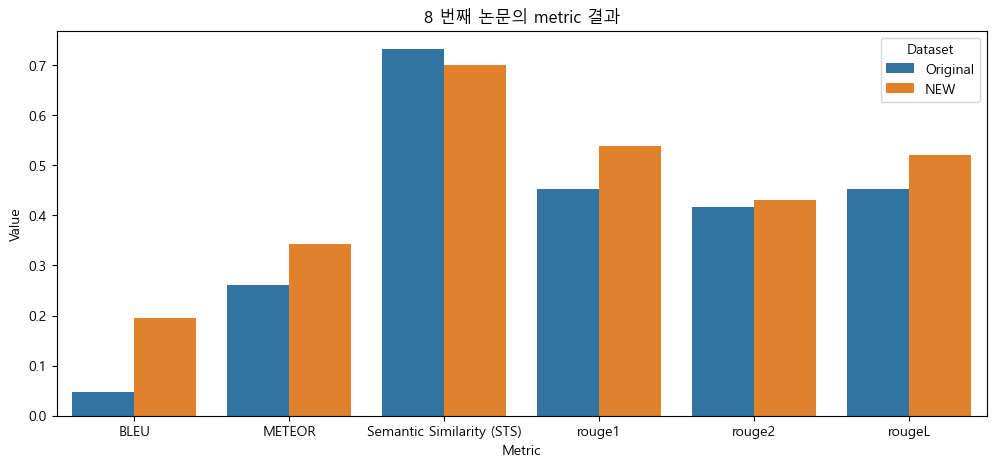

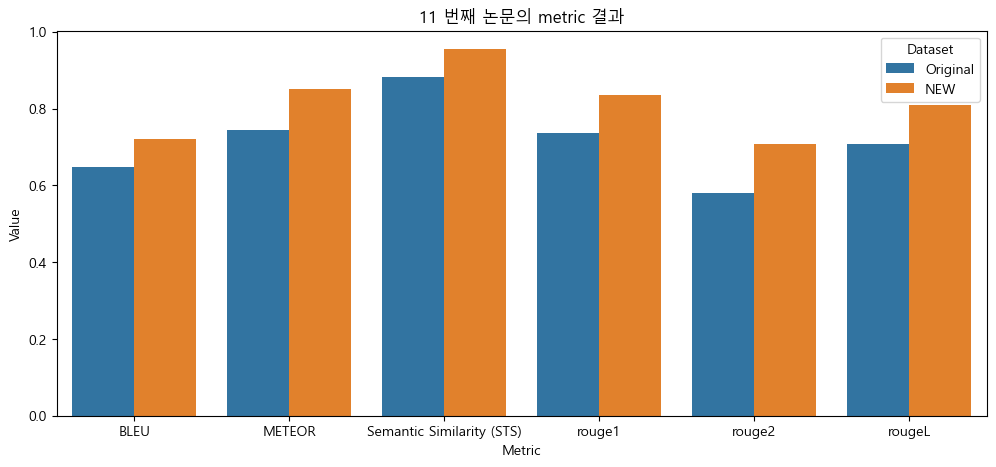

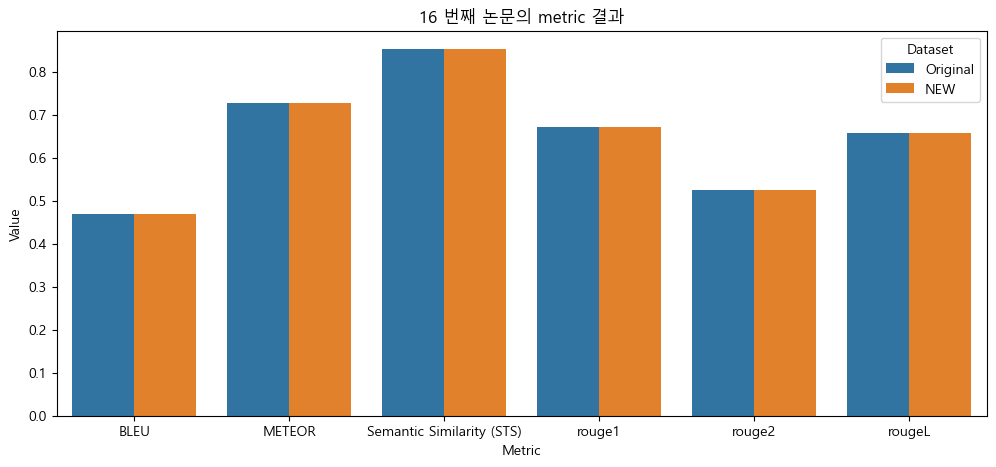

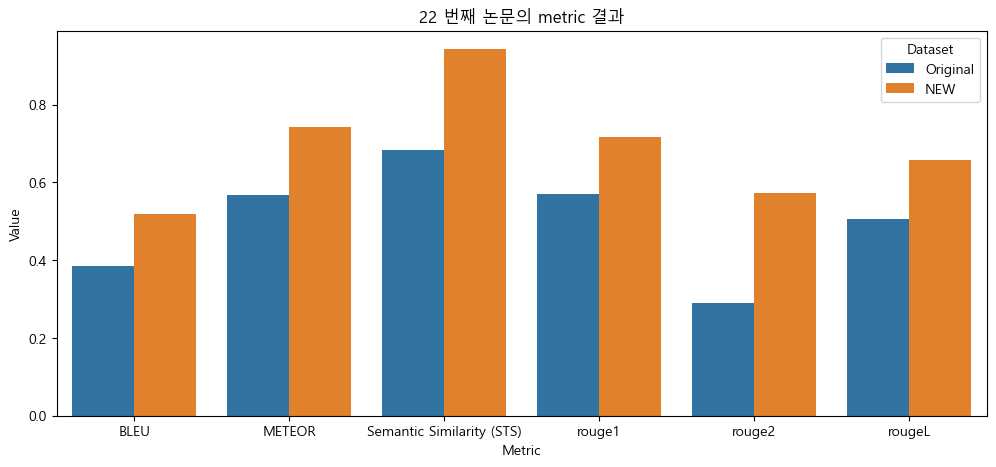

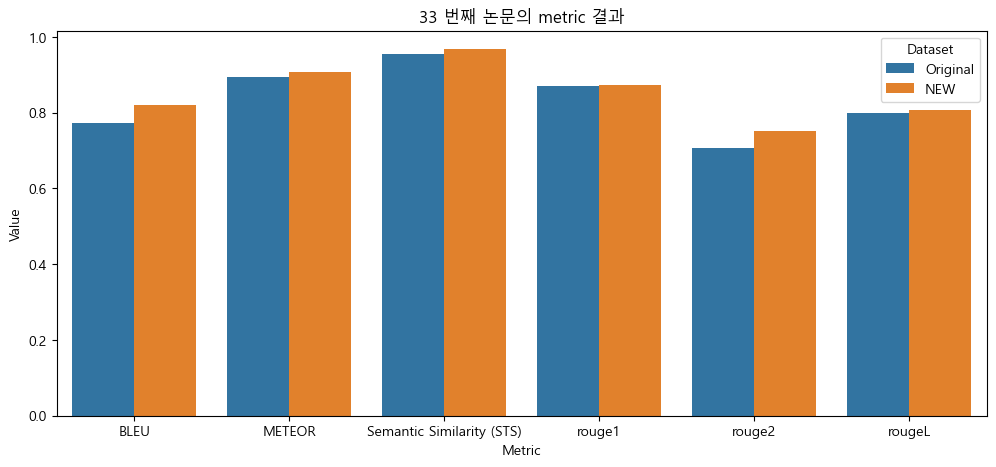

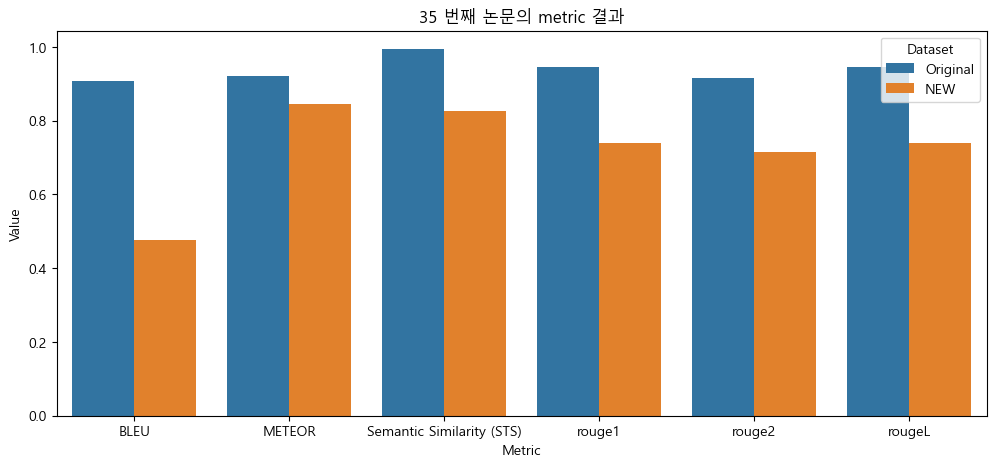

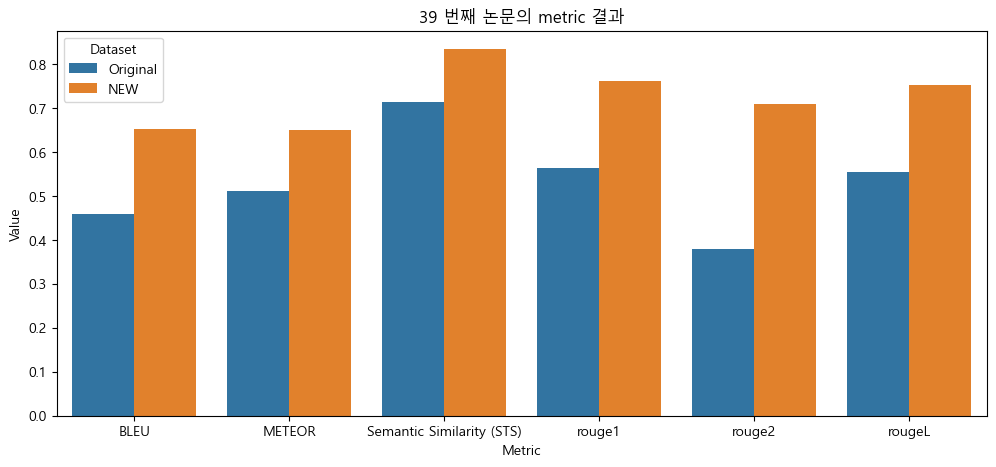

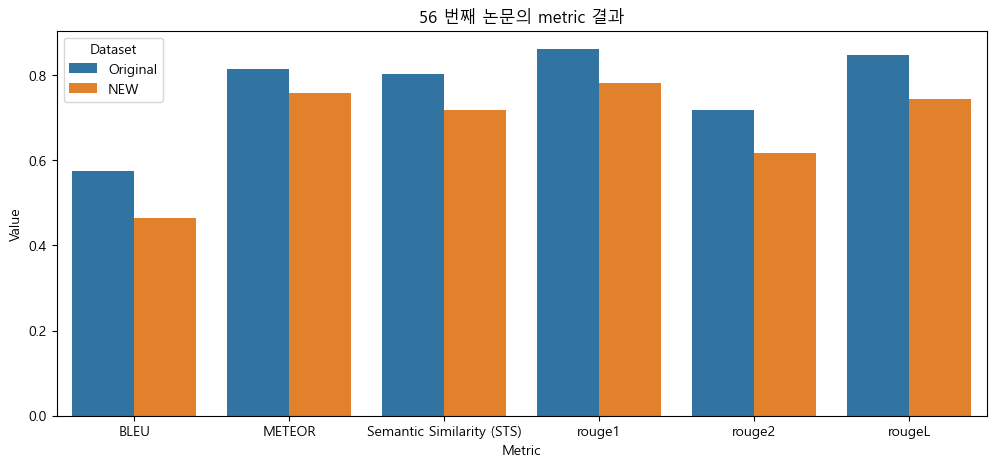

In [58]:
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# 한글 폰트 경로 설정 (예: 맑은 고딕)
font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows의 맑은 고딕 경로
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()
# 마이너스 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

for num in file_num_list:
    plt.figure(figsize=(12,5))
    temp_df = q1_eval_df[q1_eval_df["paper_number"] == num][metric_columns]
    temp_df = temp_df.melt(var_name="Metric", value_name="Value")
    temp_df["Dataset"] = "Original"

    temp_dfNEW = q1_eval_dfNEW[q1_eval_dfNEW["paper_number"] == num][metric_columns]
    temp_dfNEW = temp_dfNEW.melt(var_name="Metric", value_name="Value")
    temp_dfNEW["Dataset"] = "NEW"

    combined_df = pd.concat([temp_df, temp_dfNEW])    
    
    sns.barplot(data=combined_df, x="Metric", y="Value", hue="Dataset")
    plt.title(f"{num} 번째 논문의 metric 결과")
    plt.show()

#### metric 별 분석

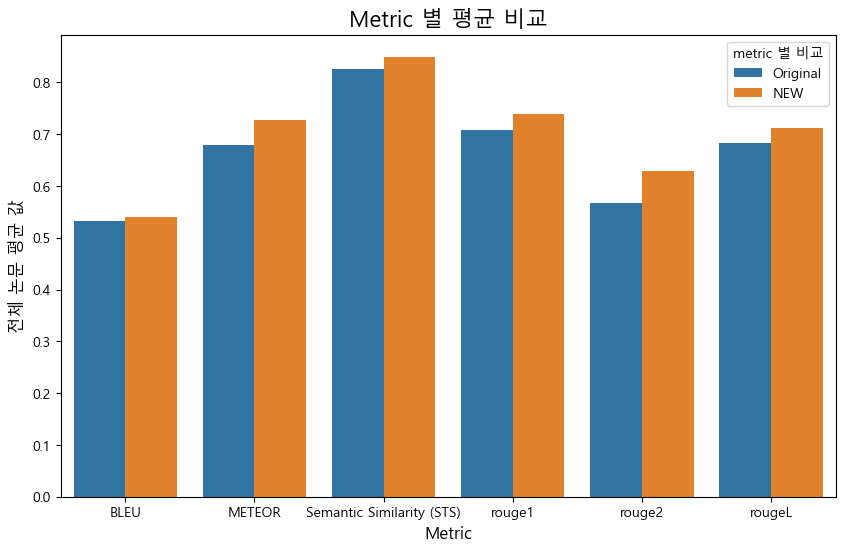

In [73]:
# `metric` 별 평균 값 계산
mean_original = q1_eval_df[metric_columns].mean().reset_index()
mean_original.columns = ["Metric", "Value"]
mean_original["Dataset"] = "Original"

mean_new = q1_eval_dfNEW[metric_columns].mean().reset_index()
mean_new.columns = ["Metric", "Value"]
mean_new["Dataset"] = "NEW"

# 데이터 결합
combined_mean = pd.concat([mean_original, mean_new])

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_mean, x="Metric", y="Value", hue="Dataset", dodge=True)

# 플롯 제목 및 레이블 설정
plt.title("Metric 별 평균 비교", fontsize=16)
plt.xlabel("Metric", fontsize=12)
plt.ylabel("전체 논문 평균 값", fontsize=12)
plt.legend(title="metric 별 비교", fontsize=10)
plt.show()